### [Covariance](https://scikit-learn.org/stable/modules/covariance.html)

- Can be described as an estimate of a dataset's scatter plot shape.

### [Empirical (observed) Covariance](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EmpiricalCovariance.html#sklearn.covariance.EmpiricalCovariance)

- A dataset's covariance matrix is well approximated by *maximum likelihood estimation (MLE)*, **if** the #observations is sufficiently large compared to the #features.

- Empirical covariance results depend on whether the data is *centered*. If e `assume_centered=False`, the test set is supposed to have the same mean vector as the training set. If not, both should be centered by the user - and `assume_centered=True` should be used.

### [Shrunk Covariance]()

- MLE is **not** a good estimator of a covariance matrix's eigenvalues - so the *precision matrix* (from its inversion) is not accurate. Sometimes an empirical covariance matrix *cannot be inverted*, for numerical reasons.

- To avoid this problem, Scikit-Learn offers a transformation via a *user-defined shrinkage coefficient*. 

- The shrinkage is defined as reducing *the ratio between the smallest & largest eigenvalues* of the empirical covariance matrix. It shifts every eigenvalue by a given offset, which is equivalent to finding an L2-penalized MLE of the covariance matrix.

- Mathematically, the shrinkage is $\Sigma_{\rm
shrunk} = (1-\alpha)\hat{\Sigma} + \alpha\frac{{\rm
Tr}\hat{\Sigma}}{p}\rm Id$ where $\alpha$ defines a bias/variance tradeoff.

### [Ledoit-Wolf (LW) shrinkage](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.LedoitWolf.html#sklearn.covariance.LedoitWolf)

- The LW covariance matrix estimator is based on a paper that finds an optimal shrinkage coefficient ($\alpha$) that minimizes MLE between the estimated & read covariance matrices.

### [Oracle Approximating Shrinkage (OAS)](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.OAS.html#sklearn.covariance.OAS)

- If a dataset is Gaussian, OAS uses another formula to choose a shrinkage coefficient that yields a smaller MLE than LW.


### [Example: LW vs OAS](https://scikit-learn.org/stable/auto_examples/covariance/plot_lw_vs_oas.html)

- Compares LSE on Gaussian data.
- [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix)
- [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz, cholesky
from sklearn.covariance import LedoitWolf as LW, OAS

In [7]:
np.random.seed(0)
n_features      = 100
r               = 0.1
real_cov        = toeplitz(r ** np.arange(n_features))
coloring_matrix = cholesky(real_cov)
n_samples_range = np.arange(6, 31, 1)
repeat          = 100
lw_mse          = np.zeros((n_samples_range.size, repeat))
oa_mse          = np.zeros((n_samples_range.size, repeat))
lw_shrinkage    = np.zeros((n_samples_range.size, repeat))
oa_shrinkage    = np.zeros((n_samples_range.size, repeat))

for i, n_samples in enumerate(n_samples_range):
    for j in range(repeat):
        X = np.dot(
            np.random.normal(size=(n_samples, n_features)), 
            coloring_matrix.T)

        lw = LW(store_precision=False, 
                assume_centered=True); lw.fit(X)
        
        lw_mse[i, j] = lw.error_norm(real_cov, 
                                     scaling=False)
        lw_shrinkage[i, j] = lw.shrinkage_

        oa = OAS(store_precision=False, 
                 assume_centered=True); oa.fit(X)
        
        oa_mse[i, j] = oa.error_norm(real_cov, 
                                     scaling=False)
        oa_shrinkage[i, j] = oa.shrinkage_

(5.0, 31.0)

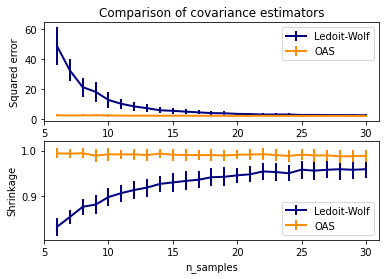

In [8]:
plt.subplot(2, 1, 1)
plt.errorbar(n_samples_range, 
             lw_mse.mean(1), 
             yerr=lw_mse.std(1),
             label='Ledoit-Wolf', 
             color='navy', lw=2)

plt.errorbar(n_samples_range, 
             oa_mse.mean(1), 
             yerr=oa_mse.std(1),
             label='OAS', 
             color='darkorange', lw=2)

plt.ylabel("Squared error")
plt.legend(loc="upper right")
plt.title("Comparison of covariance estimators")
plt.xlim(5, 31)

# plot shrinkage coefficient
plt.subplot(2, 1, 2)
plt.errorbar(n_samples_range, 
             lw_shrinkage.mean(1), 
             yerr=lw_shrinkage.std(1),
             label='Ledoit-Wolf', 
             color='navy', lw=2)

plt.errorbar(n_samples_range, 
             oa_shrinkage.mean(1), 
             yerr=oa_shrinkage.std(1),
             label='OAS', 
             color='darkorange', lw=2)

plt.xlabel("n_samples")
plt.ylabel("Shrinkage")
plt.legend(loc="lower right")

plt.ylim(plt.ylim()[0], 1. + (plt.ylim()[1] - plt.ylim()[0]) / 10.)
plt.xlim(5, 31)

### [Example: LW vs OAS vs MLE](https://scikit-learn.org/stable/auto_examples/covariance/plot_covariance_estimation.html)

- Illustrates 3 methods for setting the bias-variance tradeoff used in shrunk covariance estimators: cross-validation, LW & OAS.

- Plot the *likelihood of unseen data* vs shrinkage.

- Note: MLE corresponds to no shrinkage - and performs poorly. LW performs well. OAS is slightly further away.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.covariance import LedoitWolf as LW, OAS, \
ShrunkCovariance as SC, log_likelihood as LL, empirical_covariance as EC
from sklearn.model_selection import GridSearchCV


In [2]:
np.random.seed(42)

n_features, n_samples = 40, 20
base_X_train = np.random.normal(size=(n_samples, n_features))
base_X_test  = np.random.normal(size=(n_samples, n_features))

# Color samples
coloring_matrix = np.random.normal(size=(n_features, n_features))
X_train         = np.dot(base_X_train, coloring_matrix)
X_test          = np.dot(base_X_test,  coloring_matrix)


In [3]:
# Compute the likelihood on test data

shrinkages = np.logspace(-2, 0, 30)
negative_logliks = [-SC(shrinkage=s).fit(X_train).score(X_test)
                    for s in shrinkages]

# under the ground-truth model (won't have access to in real life)
real_cov    = np.dot(coloring_matrix.T, coloring_matrix)
emp_cov     = EC(X_train)
loglik_real = -LL(emp_cov, linalg.inv(real_cov))

In [4]:
tuned_parameters = [{'shrinkage': shrinkages}]
cv = GridSearchCV(SC(), tuned_parameters).fit(X_train)

lw = LW(); oa = OAS()

loglik_lw = lw.fit(X_train).score(X_test)
loglik_oa = oa.fit(X_train).score(X_test)


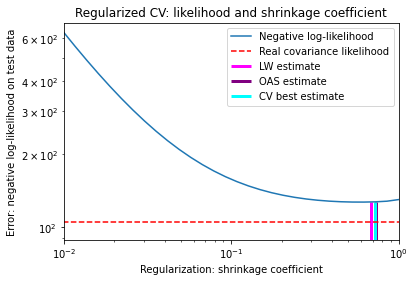

In [5]:
plt.title("Regularized CV: likelihood and shrinkage coefficient")
plt.xlabel('Regularization: shrinkage coefficient')
plt.ylabel('Error: negative log-likelihood on test data')

plt.loglog(shrinkages, 
           negative_logliks, 
           label="Negative log-likelihood")

plt.plot(plt.xlim(), 
         2*[loglik_real], '--r',
         label="Real covariance likelihood")

lik_max = np.amax(negative_logliks)
lik_min = np.amin(negative_logliks)
ymin    = lik_min -  6.*np.log((plt.ylim()[1] - plt.ylim()[0]))
ymax    = lik_max + 10.*np.log(lik_max - lik_min)
xmin    = shrinkages[0]
xmax    = shrinkages[-1]

plt.vlines(lw.shrinkage_, 
           ymin, -loglik_lw, color='magenta',
           linewidth=3, label='LW estimate')

plt.vlines(oa.shrinkage_, ymin, -loglik_oa, color='purple',
           linewidth=3, label='OAS estimate')

plt.vlines(cv.best_estimator_.shrinkage, ymin,
           -cv.best_estimator_.score(X_test), color='cyan',
           linewidth=3, label='CV best estimate')

plt.ylim(ymin, ymax)
plt.xlim(xmin, xmax)
plt.legend()

### [Sparse Inverse Covariance, aka Precision Matrix]()

- It provides a partial independence relation. (If 2 features are independent conditionally of the others, the corresponding coefficient will be zero.

- This is why estimating a sparse precision matrix makes sense; the estimate is better conditioned by learning independence relations from the data. This is known as *covariance selection*.

### [Example: sparse inverse covariance estimates](https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html)

- Uses the Graphical Lasso estimator to learn a covariance and sparse precision from a small number of samples.

- If we use L2 shrinkage (as with LW) - the #samples is small & we need to shrink a lot. So LW precision is close to the ground truth precision, but the off-diagonal structure is lost.

- The L1-penalized estimator recovers some of the off-diagonal structure. It can't find the exact sparsity pattern (it finds too many non-zero coeffs.) However, the highest non-zero coeffs correspond to ground truth. 

- The L1 precision estimate coefficients are biased towards zero. They are all smaller than the corresponding ground truth value because of the penalty.

- The color range of the precision matrices is tweaked for readability. (the full range of empirical precision values is not shown.)

- `alpha` of GraphicalLasso (the sparsity setting) is set by cross validation.

In [9]:
import numpy as np
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV as GLCV, ledoit_wolf as LW
import matplotlib.pyplot as plt

In [10]:
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98,
                              smallest_coef=.4,
                              largest_coef=.7,
                              random_state=prng)
cov   = linalg.inv(prec)
d     = np.sqrt(np.diag(cov))
cov  /= d
cov  /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X     = prng.multivariate_normal(np.zeros(n_features), 
                                 cov, 
                                 size=n_samples)
X    -= X.mean(axis=0)
X    /= X.std(axis=0)

In [11]:
# Estimate the covariance
emp_cov    = np.dot(X.T, X) / n_samples
model      = GLCV().fit(X)
cov_       = model.covariance_
prec_      = model.precision_
lw_cov_, _ = LW(X)
lw_prec_   = linalg.inv(lw_cov_)

Text(0.5, 0, 'alpha')

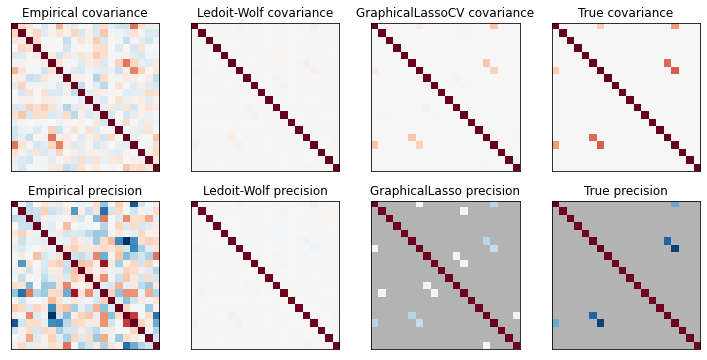

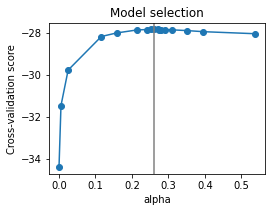

In [12]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [('Empirical',        emp_cov), 
        ('Ledoit-Wolf',      lw_cov_),
        ('GraphicalLassoCV', cov_), 
        ('True',             cov)]

vmax = cov_.max()

for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, 
               interpolation='nearest', 
               vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)

# plot the precisions
precs = [('Empirical', linalg.inv(emp_cov)), 
         ('Ledoit-Wolf',          lw_prec_),
         ('GraphicalLasso',          prec_), 
         ('True',                     prec)]

vmax = .9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(np.ma.masked_equal(this_prec, 0),
               interpolation='nearest', 
               vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r)

    plt.xticks(())
    plt.yticks(())
    plt.title('%s precision' % name)
    if hasattr(ax, 'set_facecolor'):
        ax.set_facecolor('.7')
    else:
        ax.set_axis_bgcolor('.7')

# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([.2, .15, .75, .7])
plt.plot(model.cv_results_["alphas"], 
         model.cv_results_["mean_score"], 'o-')
plt.axvline(model.alpha_, color='.5')
plt.title('Model selection')
plt.ylabel('Cross-validation score')
plt.xlabel('alpha')

### Outliers and [Minimum Covariance Determinant (MCD) estimators](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.MinCovDet.html#sklearn.covariance.MinCovDet)

- Real-world datasets are often subject to errors and uncommon observations, aka *outliers*.

- Empirical and shrunk covariance estimators are very sensitive to outliers. *Robust* cv estimators can perform outlier detection & discard/downweight outlying data.

- The **Minimum Covariance Determinant** estimator finds a proportion ($h$) of non-outlying observations & build their empirical cv matrix. This cv matrix is then scaled to compensate for a "consistency step" (?).

- This estimator can be used to give weights to observations according to their [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance), leading to a re-weighted version of the cv matrix.

- The **FastMCD algorithm** is used to build the MCD object.

### [Example: covariance estimates and Mahalanaobis distances](https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html)

- For Gaussian data: the distance of an observation to the mode of the distribution can be found using its *Mahalanobis distance*:
$d_{(\mu,\Sigma)}(x_i)^2 = (x_i - \mu)^T\Sigma^{-1}(x_i - \mu)$
where $\mu$ and $\Sigma$ are the location & covariance of the underlying Gaussian.

- In practice, $\mu$ and $\Sigma$ are replaced with estimates. MLE is very sensitive to outliers - therefore the downstream Mahalanobis distances are.

- It's better to use MCD to guarantee a measure of resistance to outliers.

- This example shows how Mahalaobis distances are altered by outliers: when using standard covariance MLE distances, contaminated observations can't be distinguished from a real Gaussian. The differences become clear using MCD-based Mahalanobis distances.

In [13]:
import numpy as np
np.random.seed(7)

# gaussian dataset; 125 samples, 2 features (both Gaussian)
# feature 1: mean = 0, stdev = 2
# feature 2: mean = 0, stdev = 1
# 25 samples replaced with Gaussian outliers:
# feature 1: mean = 0, stdev = 1
# feature 2: mean = 0, stdev = 7

n_samples = 125; n_outliers = 25; n_features = 2

# generate Gaussian data of shape (125, 2)
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), 
             np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), 
                         outliers_cov)

In [14]:
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance, MinCovDet

robust_cov = MinCovDet().fit(X)
emp_cov = EmpiricalCovariance().fit(X)

print('Estimated covariance matrix:\n'
      'MCD (Robust):\n{}\n'
      'MLE:\n{}'.format(robust_cov.covariance_, emp_cov.covariance_))

Estimated covariance matrix:
MCD (Robust):
[[ 3.26253567e+00 -3.06695631e-03]
 [-3.06695631e-03  1.22747343e+00]]
MLE:
[[ 3.23773583 -0.24640578]
 [-0.24640578  7.51963999]]


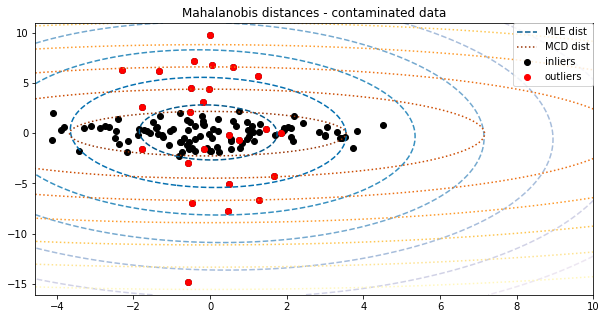

In [15]:
# plot Mahalanobis distance contours for both methods.
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], 
                         X[:, 1],
                         color='black', label='inliers')
outlier_plot = ax.scatter(X[:, 0][-n_outliers:], 
                          X[:, 1][-n_outliers:],
                          color='red', label='outliers')
ax.set_xlim(ax.get_xlim()[0], 10.)
ax.set_title("Mahalanobis distances - contaminated data")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov   = emp_cov.mahalanobis(zz)
mahal_emp_cov   = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(xx, yy, 
                              np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r, linestyles='dashed')

# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour   = ax.contour(xx, yy, 
                              np.sqrt(mahal_robust_cov),
                              cmap=plt.cm.YlOrBr_r, linestyles='dotted')

# Add legend
ax.legend([emp_cov_contour.collections[1], 
           robust_contour.collections[1],
          inlier_plot, outlier_plot],
          ['MLE dist', 'MCD dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)

- Show ability of MCD-based Mahalanobis distances to distinguish outliers.
- The cubic root of Mahalanobis distances yield roughly normal distributions.
- Plot inlier & outlier values with boxplots.
- Outlier distributions should be more separated from the inlier distributions.

Text(0.5, 1.0, 'Robust estimates\n(MCD)')

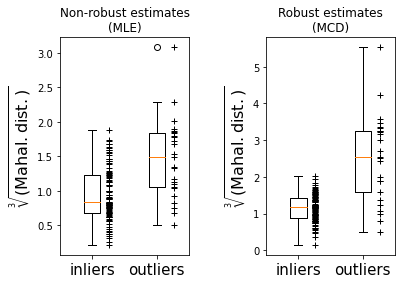

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=.6)

# Calculate cubic root of MLE Mahalanobis distances for samples
# Calculate cubic root of MCD Mahalanobis distances for samples
emp_mahal       = emp_cov.mahalanobis(X -        np.mean(X, 0)) ** (0.33)
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)

# Plot boxplots
ax1.boxplot(   [emp_mahal[:-n_outliers],    emp_mahal[-n_outliers:]], widths=.25)
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]], widths=.25)

# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), 
         emp_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), 
         emp_mahal[-n_outliers:],
         '+k', markeredgewidth=1)
ax2.plot(np.full(n_samples - n_outliers, 1.26), 
         robust_mahal[:-n_outliers],
         '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), 
         robust_mahal[-n_outliers:],
         '+k', markeredgewidth=1)

ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)

ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)

ax1.set_title("Non-robust estimates\n(MLE)")
ax2.set_title("Robust estimates\n(MCD)")